In [91]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [92]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")


In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)
h = df.sum(axis = 0, skipna = True) 
print(h)

value    906246
dtype: int64


In [96]:
import numpy as np
np.random.seed(seed=42)

train_range = df[df.period < '2010-01-01'].index
validate_range = df[(df.period >= '2010-01-01') & (df.period < '2014-01-01')].index
test_range = df[(df.period >= '2014-01-01') & (df.period < '2017-01-01')].index


In [97]:
a = df[df.period < '2010-01-01'].sum(axis=0)
v= df[(df.period >= '2010-01-01') & (df.period < '2014-01-01')].sum(axis=0)
t= df[(df.period >= '2014-01-01') & (df.period < '2017-01-01')].sum(axis=0)
print(a)
print(v)
print(t)

value    640520
dtype: int64
value    124376
dtype: int64
value    108104
dtype: int64


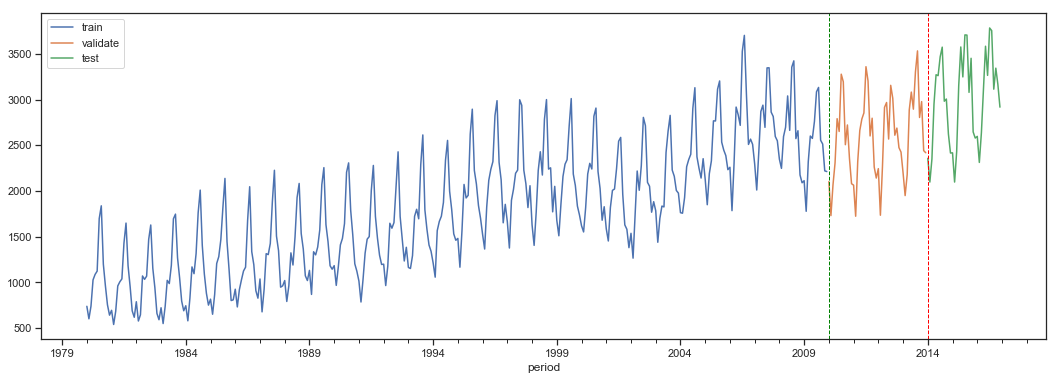

In [98]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[validate_range].plot(x="period", y="value", ax=ax, label="validate")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/ann-split.png');

In [99]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.value.astype(float).values.reshape(-1, 1));

In [100]:
def build_seasonal_learning_sequences(data, indices, seasons=12):
    train, validate, test = indices
    X_train = np.empty(shape=(0, seasons))
    y_train = np.empty(shape=(0, seasons))
    
    X_val = np.empty(shape=(0, seasons))
    y_val = np.empty(shape=(0, seasons))
    
    X_test = np.empty(shape=(0, seasons))
    y_test = np.empty(shape=(0, seasons))
    for i in range(seasons, data.shape[0] - seasons):
        X = data[i - seasons:i].reshape(1,-1)
        y = data[i:i + seasons].reshape(1,-1)
        if i in train:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)
        elif i in validate:
            X_val = np.concatenate((X_val, X), axis=0)
            y_val = np.concatenate((y_val, y), axis=0)
        elif i in test:
            X_test = np.concatenate((X_test, X), axis=0)
            y_test = np.concatenate((y_test, y), axis=0)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [101]:
seasons = 12
indices = [train_range, validate_range, test_range]

X_train, y_train, X_val, y_val, X_test, y_test = build_seasonal_learning_sequences(
    data, indices, seasons)

In [102]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [103]:
from keras import backend as K

def r2_metric(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))


def theils_u_metric(y_true, y_pred):
    SS_res =  K.mean(K.square(y_true - y_pred))
    SS_true = K.mean(K.square(y_true))
    SS_pred = K.mean(K.square(y_pred)) 
    return K.sqrt(SS_res / (SS_true * SS_pred))

In [104]:
from keras.layers import InputLayer, Dense, LSTM
from keras.models import Sequential
from keras.optimizers import SGD

sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=False)

model = Sequential()
model.add(InputLayer(input_shape=(1, seasons), name="input"))
model.add(LSTM(4, name="hidden", activation='sigmoid', use_bias = True, bias_initializer='ones'))
model.add(Dense(seasons, name="output", activation='linear', use_bias = True, bias_initializer='ones'))
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=["mae", "mse", r2_metric, theils_u_metric])

In [105]:
num_of_epochs = 40
history = model.fit(
    X_train, y_train,
    epochs=num_of_epochs,
    batch_size=1,
    verbose=0,
    validation_data=(X_val, y_val));

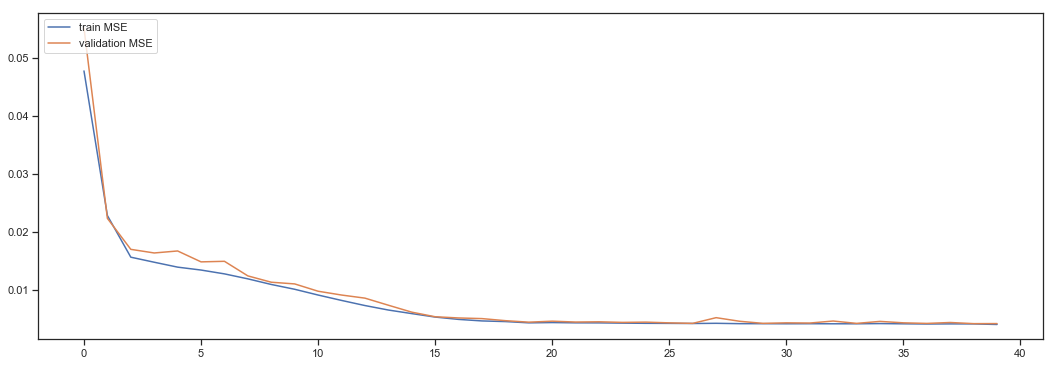

In [106]:
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(history.history["mean_squared_error"], label="train MSE")
plt.plot(history.history["val_mean_squared_error"], label="validation MSE")
plt.legend(loc='upper left')
plt.savefig('images/ann-val-history.png');

### Evaluate the model

In [107]:
_, mae, mse, r2, u = model.evaluate(X_train, y_train, batch_size=1, verbose=0)

print("MAE (train): {:0.3f}".format(mae))
print("MSE (train): {:0.3f}".format(mse))
print("R2  (train): {:0.3f}".format(r2))
print("U   (train): {:0.3f}".format(u))

MAE (train): 0.052
MSE (train): 0.004
R2  (train): 0.700
U   (train): 0.601


In [108]:
_, mae, mse, r2, u = model.evaluate(X_val, y_val, batch_size=1, verbose=0)

print("MAE (val): {:0.3f}".format(mae))
print("MSE (val): {:0.3f}".format(mse))
print("R2  (val): {:0.3f}".format(r2))
print("U   (val): {:0.3f}".format(u))

MAE (val): 0.053
MSE (val): 0.004
R2  (val): 0.730
U   (val): 0.169


### Forecast

In [109]:
yhat_train = model.predict(X_train[::seasons])
yhat_val = model.predict(X_val[::seasons])
yhat_test = model.predict(X_test[::seasons])
print(yhat_val)
yhat_train_unscaled = scaler.inverse_transform(yhat_train).flatten()
yhat_val_unscaled = scaler.inverse_transform(yhat_val).flatten()
yhat_test_unscaled = scaler.inverse_transform(yhat_test).flatten()
yhat_train = yhat_train.flatten()
yhat_val = yhat_val.flatten()
yhat_test = yhat_test.flatten()
print(yhat_val)

[[0.42478234 0.4287654  0.52870715 0.59962624 0.63650864 0.6881547
  0.7362585  0.7433754  0.64902335 0.58036476 0.5365961  0.45798635]
 [0.39490062 0.3910321  0.486827   0.5646476  0.6188634  0.6903595
  0.7531766  0.7677352  0.67896223 0.60248685 0.54196966 0.44399863]
 [0.40998062 0.4224295  0.5232534  0.6037769  0.66184574 0.730283
  0.77996445 0.77779686 0.6883738  0.6065969  0.54238605 0.44742513]
 [0.47453335 0.46744215 0.5669779  0.6325009  0.6540187  0.6952363
  0.74597126 0.7641744  0.6644159  0.60457927 0.5753315  0.5071204 ]]
[0.42478234 0.4287654  0.52870715 0.59962624 0.63650864 0.6881547
 0.7362585  0.7433754  0.64902335 0.58036476 0.5365961  0.45798635
 0.39490062 0.3910321  0.486827   0.5646476  0.6188634  0.6903595
 0.7531766  0.7677352  0.67896223 0.60248685 0.54196966 0.44399863
 0.40998062 0.4224295  0.5232534  0.6037769  0.66184574 0.730283
 0.77996445 0.77779686 0.6883738  0.6065969  0.54238605 0.44742513
 0.47453335 0.46744215 0.5669779  0.6325009  0.6540187  0.

In [114]:
y_train_unscaled = scaler.inverse_transform(y_train[::seasons]).flatten()
print(type(y_train_unscaled))
y_val_unscaled = scaler.inverse_transform(y_val[::seasons]).flatten()
y_test_unscaled = scaler.inverse_transform(y_test[::seasons]).flatten()

ValueError: Expected 2D array, got 1D array instead:
array=[0.04504505 0.         0.04213891 0.12263877 0.13571636 0.14501598
 0.25864574 0.32258065 0.18628306 0.12031386 0.04330137 0.02295844
 0.07236269 0.0110433  0.030805   0.15431561 0.14356292 0.15373438
 0.27056088 0.31647777 0.17872711 0.11711712 0.0351642  0.01511189
 0.05318221 0.00290613 0.05812264 0.14036617 0.13019471 0.18860796
 0.33623947 0.35106074 0.21185702 0.14850334 0.07439698 0.04359198
 0.0595757  0.01162453 0.0836966  0.18308631 0.16158094 0.22551584
 0.35541994 0.42749201 0.25167103 0.1607091  0.09938971 0.06161
 0.08049985 0.03254868 0.09503051 0.19412961 0.21563499 0.26968904
 0.37169427 0.4646905  0.26358617 0.17436792 0.07614066 0.07817495
 0.11217669 0.05579773 0.11072363 0.14181924 0.17000872 0.18221447
 0.33129904 0.4382447  0.23161872 0.19035164 0.10752688 0.0836966
 0.14472537 0.04010462 0.11188608 0.22522523 0.22231909 0.2577739
 0.39029352 0.49055507 0.28102296 0.23481546 0.11857018 0.12292938
 0.13978495 0.07323452 0.12321999 0.22784074 0.18918919 0.27840744
 0.40395234 0.44870677 0.28916013 0.2400465  0.15489683 0.13978495
 0.17204301 0.09561174 0.2313281  0.22144725 0.24643999 0.30078466
 0.4449288  0.49898285 0.31764022 0.26387678 0.18686428 0.17582098
 0.1871549  0.12438245 0.18337693 0.25312409 0.27375763 0.32083697
 0.48416158 0.51409474 0.36355711 0.28596338 0.19296716 0.16942749
 0.13804127 0.07149085 0.14385353 0.2269689  0.27143272 0.27956989
 0.42632956 0.50595757 0.34408602 0.27433885 0.22057541 0.19093287
 0.19180471 0.12380122 0.18570183 0.32199942 0.30630631 0.32403371
 0.43504795 0.54925894 0.34321418 0.27404824 0.20197617 0.24556815
 0.18134263 0.17814589 0.21912235 0.34408602 0.36646324 0.33623947
 0.50857309 0.60302238 0.36471956 0.30281895 0.25283348 0.23278117
 0.19587329 0.15053763 0.29875036 0.32781168 0.34437663 0.38825923
 0.52252252 0.58558559 0.42371404 0.36617262 0.28828829 0.26794536
 0.27375763 0.18221447 0.29875036 0.44551003 0.40249927 0.41092706
 0.6056379  0.6849753  0.48997384 0.44667248 0.37837838 0.33798314
 0.28654461 0.2400465  0.37401918 0.45858762 0.49375182 0.51816332
 0.66434176 0.71200232 0.51554781 0.46004069 0.32345248 0.38215635
 0.32664923 0.24324324 0.39494333 0.43039814 0.48096484 0.4911363
 0.71490846 0.69718105 0.49084568 0.44812554 0.37198489 0.44144144
 0.31705899 0.25167103 0.35658239 0.49026446 0.54954955 0.47544319
 0.65242662 0.71548968 0.49433304 0.49840163 0.35832607 0.43940715
 0.33129904 0.28218541 0.38215635 0.47108399 0.51002616 0.5242662
 0.63121186 0.71868643 0.47863993 0.44202267 0.3766347  0.34844522
 0.31415286 0.29439117 0.37169427 0.47863993 0.51264167 0.49462366
 0.66259808 0.68846266 0.48648649 0.43243243 0.33158965 0.37460041
 0.30456263 0.26562046 0.37198489 0.42662017 0.43097937 0.49636734
 0.58297007 0.59517582 0.41383319 0.31676838 0.30281895 0.2444057
 0.29003197 0.21098518 0.35280442 0.48823017 0.42691078 0.50566696
 0.65882011 0.63237431 0.45219413 0.43969776 0.35716362 0.39058413
 0.36181343 0.26155187 0.33740192 0.3766347  0.37401918 0.54693403
 0.61522813 0.6652136  0.4911363  0.4713746  0.42632956 0.41790177
 0.35571055 0.35396687 0.40366173 0.50188899 0.52455681 0.54141238
 0.6873002  0.7532694  0.53327521 0.49694856 0.46585295 0.52746295
 0.46178437 0.3809939  0.47980238 0.52048823 0.64777681 0.6474862
 0.74861959 0.77477477 0.58006393 0.55478059 0.5373438  0.49258936
 0.50014531 0.36210404 0.51264167 0.6916594  0.66724789 0.63353676
 0.86893345 0.91979076 0.73263586 0.57279861 0.58965417 0.57308922
 0.51089799 0.42778262 0.5483871  0.67770997 0.69776228 0.62714327
 0.81633246 0.81662307 0.67567568 0.66172624 0.59808195 0.58442313
 0.52571927 0.49665795 0.59779134 0.62743389 0.72711421 0.61755304
 0.81865737 0.83870968 0.59139785 0.61639058 0.4757338  0.45074106
 0.45742517 0.36006975 0.51729149 0.59953502 0.59197908 0.64603313
 0.7401918  0.75414124 0.58616681 0.57396106 0.48881139 0.48648649].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Evaluate the forecast

In [111]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))
#_, mae, mse, r2, u = model.evaluate(X_test, y_test, batch_size=1, verbose=0)
mae = mean_absolute_error(y_train_unscaled, yhat_train_unscaled)
mse = mean_squared_error(y_train_unscaled, yhat_train_unscaled)
r2 = r2_score(y_train_unscaled, yhat_train_unscaled)
u = theils_u_metric(y_train_unscaled, yhat_train_unscaled)
#mae = mean_absolute_error(y_train, yhat_train)
#mse = mean_squared_error(y_train, yhat_train)
#r2 = r2_score(y_train, yhat_train)
#u = theils_u_metric(y_train, yhat_train)

print("MAE (train): {:0.0f}".format(mae))
print("MSE (train): {:0.0f}".format(mse))
print("R2  (train): {:0.3f}".format(r2))
print("U   (train): {:0.6f}".format(u))

MAE (train): 157
MSE (train): 37973
R2  (train): 0.917
U   (train): 0.000052


In [115]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))
#_, mae, mse, r2, u = model.evaluate(X_test, y_test, batch_size=1, verbose=0)
mae = mean_absolute_error(y_val_unscaled, yhat_val_unscaled)
mse = mean_squared_error(y_val_unscaled, yhat_val_unscaled)
r2 = r2_score(y_val_unscaled, yhat_val_unscaled)
u = theils_u_metric(y_val_unscaled, yhat_val_unscaled)

print("MAE (val): {:0.0f}".format(mae))
print("MSE (val): {:0.0f}".format(mse))
print("R2  (val): {:0.3f}".format(r2))
print("U   (val): {:0.6f}".format(u))

MAE (val): 180
MSE (val): 44581
R2  (val): 0.778
U   (val): 0.000031


In [116]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))
#_, mae, mse, r2, u = model.evaluate(X_test, y_test, batch_size=1, verbose=0)
mae = mean_absolute_error(y_test_unscaled, yhat_test_unscaled)
mse = mean_squared_error(y_test_unscaled, yhat_test_unscaled)
r2 = r2_score(y_test_unscaled, yhat_test_unscaled)
u = theils_u_metric(y_test_unscaled, yhat_test_unscaled)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))


MAE (test): 248
MSE (test): 88958
R2  (test): 0.635
U   (test): 0.000034
value    0.002292
dtype: float64
value    0.82289
dtype: float64


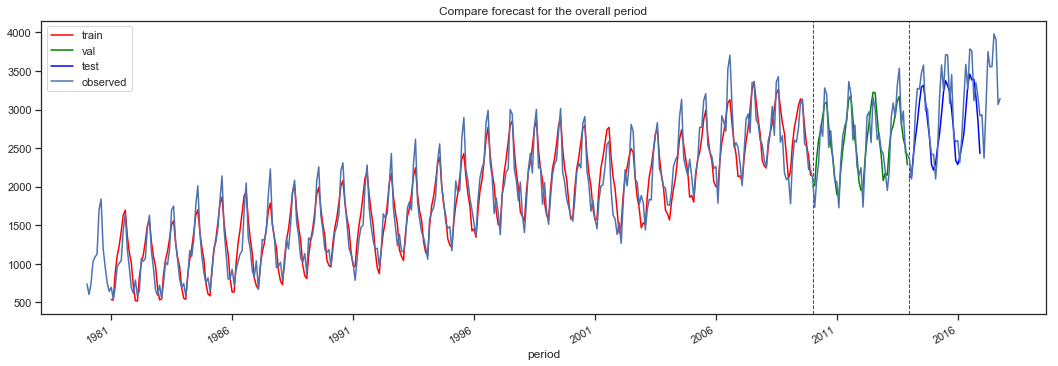

In [24]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[train_range].period.values)[seasons:], yhat_train_unscaled,
        color="red", label="train")
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="green", label="val")
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the overall period')

plt.savefig('images/ann-compare-forecast-overall.png')
plt.show();

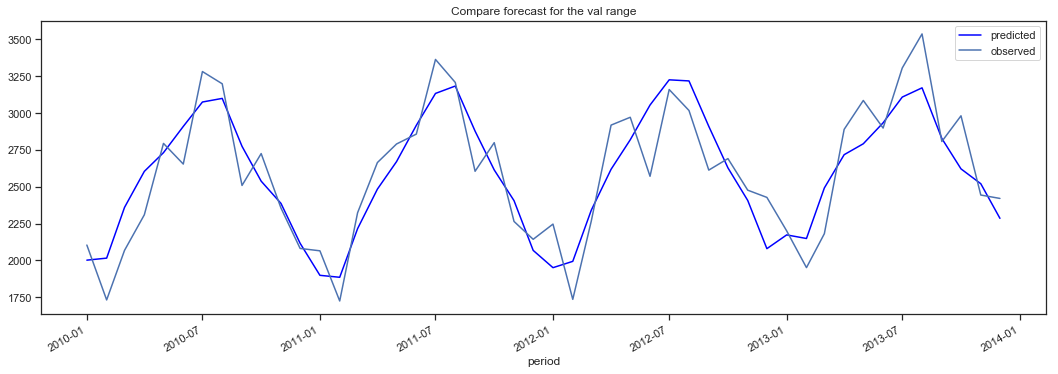

In [25]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="blue", label="predicted")

df.loc[validate_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the val range')

plt.savefig('images/ann-compare-forecast-valrange.png')
plt.show();

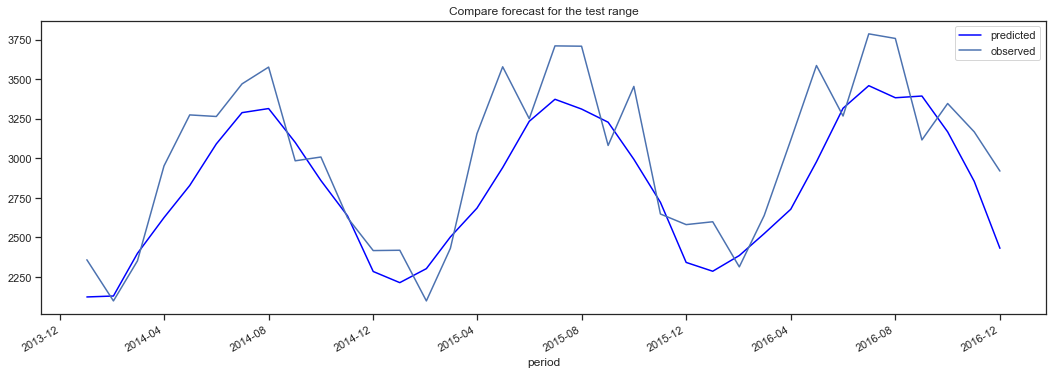

In [26]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.savefig('images/ann-compare-forecast-testrange.png')
plt.show();